In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import math, time, random, datetime

import numpy as np
import pandas as pd

import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


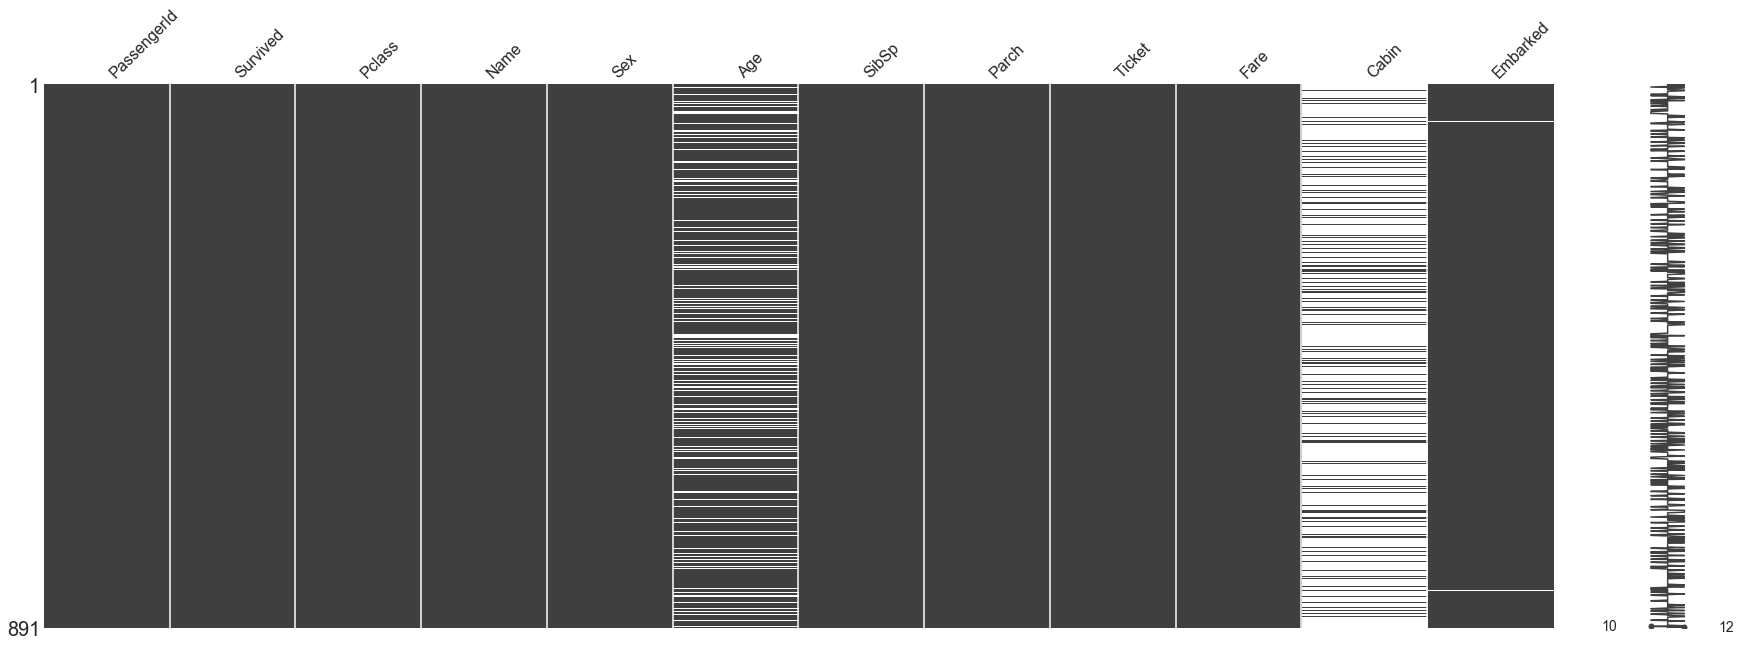

In [5]:
missingno.matrix(train, figsize = (30,10))

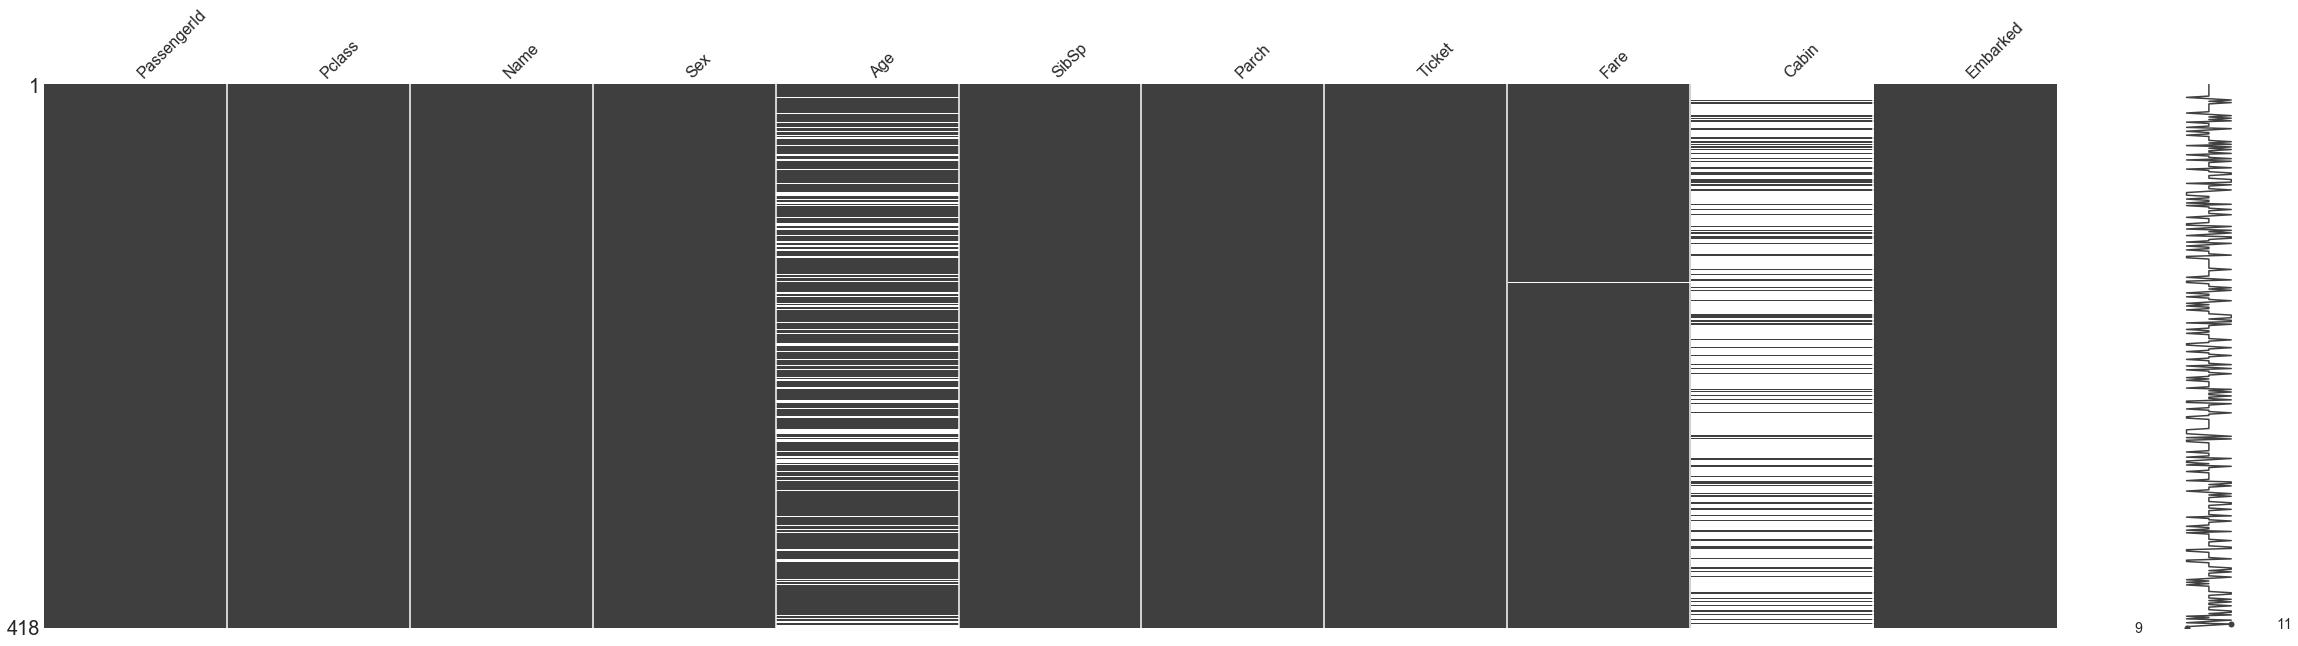

In [6]:
missingno.matrix(test, figsize = (40,10))

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
def get_title(name) :
    title = 'NA'
    if '.' in name :
        title = name.split(',')[1].split('.')[0].strip()
    if title in ['Dr', 'Rev', 'Col', 'Major', 'Don', 'Lady', 'Capt', 'Jonkheer', 'the Countess', 'Sir'] :
        return 'Rare'
    elif title in ['Mlle', 'Ms'] :
        return 'Miss'
    elif title in ['Mme'] :
        return 'Mrs'
    elif title not in ['Mr', 'Miss', 'Mrs', 'Master'] :
        return 'NA'
    else :
        return title

data = [train, test]
for dataset in data:
    dataset['Title'] = dataset['Name'].map(lambda x: get_title(x))
    dataset.drop(columns =["Name"], inplace = True)

In [9]:
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.drop(columns =['SibSp', 'Parch'], inplace = True) 

In [10]:
test_passengers = test['PassengerId']

for dataset in data:
    dataset.drop(columns =['PassengerId'], inplace = True) 
    dataset.drop(columns =['Ticket'], inplace = True)

In [11]:
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('Unknown')
    dataset['Deck'] = dataset['Cabin'].map(lambda x: x[0])
    dataset.drop(columns =['Cabin'], inplace = True)

In [12]:
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())

In [13]:
common_value = 'S'

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [14]:
def fill_age(title, age, sex, mean_age, std_age) :
    if np.isnan(age) :
        return np.random.randint(mean[title, sex] - std[title, sex], mean[title, sex] + std[title, sex])
    return age

mean = train.groupby(['Title', 'Sex']).mean()['Age']
std = train.groupby(['Title', 'Sex']).std()['Age']
for dataset in data:
    dataset['Age'] = dataset.apply(lambda x: fill_age(title = x['Title'], age = x['Age'], sex = x['Sex'], mean_age = mean, std_age = std), axis=1)

In [15]:
genders = {"male": 0, "female": 1}
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [16]:
ports = {"S": 0, "C": 1, "Q": 2}
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [17]:
normalize_cols = ['Age', 'Fare']
one_hot_cols = ['Pclass', 'Sex', 'Embarked', 'Title', 'Relatives', 'Deck']

In [18]:
for dataset in data:
    for col in normalize_cols :
        dataset[col] = (dataset[col] - dataset[col].mean()) / dataset[col].std()

In [19]:
train = pd.get_dummies(train, columns=one_hot_cols, dtype=float)
test = pd.get_dummies(test, columns=one_hot_cols, dtype=float)

In [20]:
target = train['Survived']
train.drop(columns =['Survived'], inplace = True)

In [21]:
test.head(15)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,...,Relatives_7,Relatives_10,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,0.338277,-0.497811,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.263912,-0.512660,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.374674,-0.464532,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.217103,-0.482888,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.587357,-0.417971,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,-1.179764,-0.472814,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.005049,-0.501392,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,-0.291154,-0.118681,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,-0.883561,-0.508555,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,-0.661408,-0.205535,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
test.head(15)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,...,Relatives_7,Relatives_10,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,0.338277,-0.497811,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.263912,-0.512660,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.374674,-0.464532,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.217103,-0.482888,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.587357,-0.417971,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,-1.179764,-0.472814,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.005049,-0.501392,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,-0.291154,-0.118681,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,-0.883561,-0.508555,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,-0.661408,-0.205535,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
titanic_data = torch.tensor(train[:700].values)
titanic_data_target = torch.tensor(target[:700].values).view(-1,1)
titanic_validate = torch.tensor(train[700:791].values)
titanic_validate_target = torch.tensor(target[700:791].values).view(-1,1)
titanic_test = torch.tensor(train[791:891].values)
titanic_test_target = torch.tensor(target[791:891].values).view(-1,1)
print(train.shape, titanic_data.shape, titanic_data_target.shape, titanic_validate.shape, titanic_validate_target.shape, titanic_test.shape, titanic_test_target.shape)

(891, 33) torch.Size([700, 33]) torch.Size([700, 1]) torch.Size([91, 33]) torch.Size([91, 1]) torch.Size([100, 33]) torch.Size([100, 1])


In [24]:
class TitanicNN(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        self.fc1 = nn.Linear(33, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 1)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x) :
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        
        x = F.sigmoid(self.fc6(x))
        
        return x

In [25]:
titanic_nn = TitanicNN()

criterion = nn.BCELoss()

optimizer = optim.SGD(titanic_nn.parameters(), lr = 0.03)

In [26]:
epochs = 50

min_valid_loss = np.Inf

titanic_nn = titanic_nn.float()

for epoch in range(epochs) :
    train_loss = 0.0
    valid_loss = 0.0
    
    titanic_nn.train()
    for data, data_target in zip(titanic_data, titanic_data_target) :
        optimizer.zero_grad()
        
        output = titanic_nn(data.float())
        
        loss = criterion(output, data_target.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss = train_loss / len(titanic_data)
    
    with torch.no_grad():
        titanic_nn.eval()
        for data, data_target in zip(titanic_validate, titanic_validate_target) :
            output = titanic_nn(data.float())

            loss = criterion(output, data_target.float())

            valid_loss += loss.item()
    valid_loss = valid_loss / len(titanic_validate)
    
    print('Epoch: {}/{}... '.format(epoch + 1, epochs),
          'Training Loss {}... '.format(train_loss),
          'Validation Loss {}... '.format(valid_loss))
    
    if valid_loss < min_valid_loss :
        min_valid_loss = valid_loss
        torch.save(titanic_nn.state_dict(), 'checkpoint.pth')
        print('Model state dictionary saved in checkpoint.pth on epoch {}... '.format(epoch + 1))

C:\Users\i309649\AppData\Local\Continuum\anaconda2\envs\Python3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/50...  Training Loss 0.6741417128273419...  Validation Loss 0.6664023435377813... 
Model state dictionary saved in checkpoint.pth on epoch 1... 
Epoch: 2/50...  Training Loss 0.6696527970262937...  Validation Loss 0.6646281045216781... 
Model state dictionary saved in checkpoint.pth on epoch 2... 
Epoch: 3/50...  Training Loss 0.6658131223065512...  Validation Loss 0.6532317514602954... 
Model state dictionary saved in checkpoint.pth on epoch 3... 
Epoch: 4/50...  Training Loss 0.6307494387349912...  Validation Loss 0.5028453035341515... 
Model state dictionary saved in checkpoint.pth on epoch 4... 
Epoch: 5/50...  Training Loss 0.5829533438320297...  Validation Loss 0.44335283175274565... 
Model state dictionary saved in checkpoint.pth on epoch 5... 
Epoch: 6/50...  Training Loss 0.5445463800350471...  Validation Loss 0.4104998093712461... 
Model state dictionary saved in checkpoint.pth on epoch 6... 
Epoch: 7/50...  Training Loss 0.5213212734347742...  Validation Loss 0.4149

In [27]:
state_dict = torch.load('checkpoint.pth')
titanic_nn.load_state_dict(state_dict)

confusion_matrix = [[0, 0], [0, 0]]

with torch.no_grad():
    titanic_nn.eval()
    for data, data_target in zip(titanic_test, titanic_test_target) :
        output = titanic_nn(data.float())

        if output > 0.5 :
            output = 1
        else :
            output = 0

        confusion_matrix[data_target][output] += 1

print('confusion_matrix {}... '.format(confusion_matrix))

confusion_matrix [[61, 3], [12, 24]]... 


In [28]:
precision = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[0][1])
recall = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[1][0])
f1 = (2 * precision * recall) / (precision + recall)
print('Precision : {}'.format(precision),
      'Recall : {}'.format(recall),
      'F1 Score : {}'.format(f1))

Precision : 0.8888888888888888 Recall : 0.6666666666666666 F1 Score : 0.761904761904762


In [29]:
test_data = torch.tensor(test.values)

submission = pd.DataFrame(columns=['PassengerId', 'Survived'])

with torch.no_grad():
    titanic_nn.eval()
    
    for data, passengerId in zip(test_data, test_passengers) :
        output = titanic_nn(data.float())
        
        if output > 0.5 :
            output = 1
        else :
            output = 0
        
        submission = submission.append({'PassengerId': passengerId, 'Survived': output}, ignore_index=True)

submission.head(15)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,0
9,901,0


In [30]:
submission['Survived'].value_counts()

0    280
1    138
Name: Survived, dtype: int64

In [31]:
target.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [32]:
submission.to_csv('Titanic_NN_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!
